In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [2]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

In [3]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [4]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"{split}에 있는 질문 개수: {df['id'].nunique()}")

train에 있는 질문 개수: 1295
test에 있는 질문 개수: 358
validation에 있는 질문 개수: 255


In [5]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [6]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx   = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

In [7]:
import matplotlib.pyplot as plt

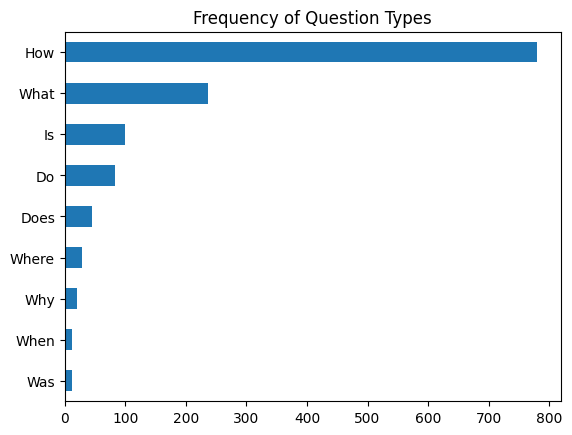

In [8]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why", "When"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [9]:
for question_type in ["How", "What", "Is", "When"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?
When the setup is complete?
When was that video recorded?
When the headphone cable are short?


In [10]:
from transformers import AutoTokenizer

In [11]:
model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [12]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."""
inputs = tokenizer(question, context, return_tensors="pt")

inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [13]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [14]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)

print(outputs)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [15]:
start_logits = outputs.start_logits
end_logits   = outputs.end_logits

In [16]:
print(f"{inputs.input_ids.size()}")
print(f"{start_logits.size()}")
print(f"{end_logits.size()}")

torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])


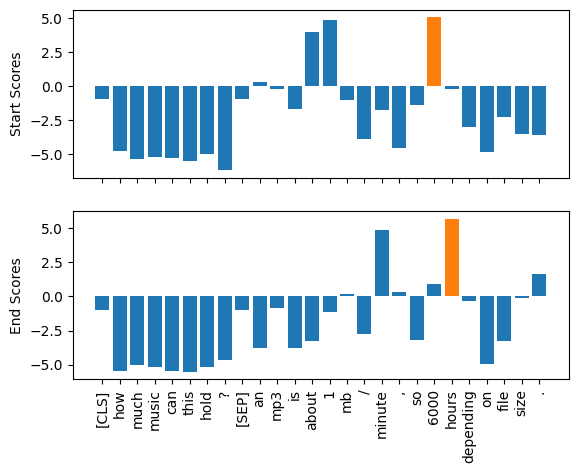

In [17]:
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")

colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")

plt.xticks(rotation="vertical")
plt.show()

In [18]:
import torch

start_idx = torch.argmax(start_logits)
end_idx   = torch.argmax(end_logits) + 1

answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)

print(f"question : {question}")
print(f"answer : {answer}")

question : How much music can this hold?
answer : 6000 hours


In [19]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)   # handle_impossible_answer = True -> 답변 불가 질문은 빈 문자열로 매핑
pipe(question=question, context=context, topk=3)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.26516109704971313,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.22082959115505219,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253564268350601,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [20]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100,
                              stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [21]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"#{idx} 윈도에는 {len(window)} 개의 토큰이 있습니다.")

#0 윈도에는 100 개의 토큰이 있습니다.
#1 윈도에는 88 개의 토큰이 있습니다.


In [22]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



https://docs.haystack.deepset.ai/docs/document_store

In [23]:
from haystack.document_stores import ElasticsearchDocumentStore

document_store = ElasticsearchDocumentStore(host = "localhost",
                                            port = 9200,
                                            embedding_dim = 768)

/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


In [24]:
for split, df in dfs.items():
    docs = [{"content": row["context"],
             "meta":{
                 "item_id": row["title"],
                 "question_id": row["id"],
                 "split": split
                 }
            }
        for _, row in df.drop_duplicates(subset="context").iterrows()
        ]
    #document_store.write_documents(docs, index="document")
    document_store.write_documents(docs)

print(f"{document_store.get_document_count()} 개 문서 저장 완료.")

1615 개 문서 저장 완료.


In [41]:
from haystack.nodes import EmbeddingRetriever

In [42]:
retriever = EmbeddingRetriever(
    document_store=document_store, embedding_model="sentence-transformers/multi-qa-mpnet-base-dot-v1"
)
document_store.update_embeddings(retriever)

modules.json: 100%|██████████| 229/229 [00:00<00:00, 67.2kB/s]
README.md: 100%|██████████| 8.66k/8.66k [00:00<00:00, 5.90MB/s]
sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<00:00, 27.8kB/s]
config.json: 100%|██████████| 571/571 [00:00<00:00, 553kB/s]
pytorch_model.bin: 100%|██████████| 438M/438M [00:31<00:00, 13.8MB/s] 
/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
tokenizer_config.json: 100%|██████████| 363/363 [00:00<00:00, 167kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 14.4MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 837kB/s]
1_Pooling/config.json: 100%|██████████| 190/19

In [43]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = retriever.retrieve(query=query, top_k=3, filters={"item_id": [item_id], "split": ["train"]})

Batches: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


In [44]:
print(retrieved_docs[0].content)
print(retrieved_docs[0].score)

I've used an e-reader since the Rocket ebook in 1999, and I've always believed I wanted only an ebook reader with no other features. I don't get out much, so my computer is convenient for everything else.I've had several Kindles and was happy with all of them, but I had recently played around with my brother's tablet. When my last Kindle died, I decided to replace it with the Kindle Fire. I chose the smaller one because I was concerned about my arthritic hands holding a larger device for long periods. The 7" is just perfect for me. It's light enough that I can hold it to read, but the larger screen compared to the Kindle makes for easier reading. I love the color, something I never thought would make a difference to me.Oddly enough, high on my favorite list is the ability to review a book as soon as I reach the end. I have written reviews of every book I read on a readers social media site, but I have seldom put in the extra effort to come to Amazon to write a review. On the Kindle Fir

In [45]:
from haystack.nodes import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
reader = FARMReader(model_name_or_path=model_ckpt, use_gpu=False)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
reader.predict_on_texts(question=question, texts=[context], top_k=1)

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  6.34 Batches/s]


{'query': 'How much music can this hold?',
 'no_ans_gap': 12.648082256317139,
 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5296427607536316, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}], 'offsets_in_context': [{'start': 38, 'end': 48}], 'document_ids': ['e344757014e804eff50faa3ecf1c9c75'], 'meta': {}}>]}

In [46]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, retriever)

In [47]:
prediction = pipe.run(
    query=query, params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
)

Batches: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s]
/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
Inferencing Samples: 100%|██████████| 1/1 [00:01<00:00,  1.47s/ Batches]


In [48]:
from haystack.utils import print_answers

print_answers(prediction, details="minimum")

'Query: Is it good for reading?'
'Answers:'
[   {   'answer': 'perfect',
        'context': "This tablet it's just what I wanted, the size and weight "
                   'are perfect for reading and internet surfing. Its pretty '
                   'fast too'},
    {   'answer': 'It will also be nice for pulling up cook books',
        'context': 'heir email, look up directions, or browse the web.  It '
                   "will also be nice for pulling up cook books. If I don't "
                   'see much use out of it for awhile I may'},
    {   'answer': "I simply can't hold the Kindle Fire long enough for reading",
        'context': 'r short periods to play a few games. However, I simply '
                   "can't hold the Kindle Fire long enough for reading. This "
                   "won't be an issue for most people, but"},
    {   'answer': 'it is perfect',
        'context': "I've been using the product to type up my notes during "
                   'class, and it is per